# Getting to Grips with JSTOR data

There is a lot of data in the zip files provided by JSTOR. How to get at it properly?

In [1]:
import os
import re
import time
import pickle as p
from math import inf

from bs4 import BeautifulSoup
from tqdm.notebook import tqdm
from nltk.tokenize import wordpunct_tokenize

from utils import JSTORCorpus

## Input pipeline

Use the JSTORCorpus class to stream in data from the DfR corpus

In [2]:
corpus = JSTORCorpus.load('data/last-15-years-corpus.p')

Corpus loaded from data/last-15-years-corpus.p


## Test input pipeline with Gensim

Gensim provides several methods for modelling a corpus as a whole. Let's try FastText and word2vec.

### How Romantic is this corpus?

The corpus was constructed by searching for the 'Romanticism' keyword. But it seems there are lots of articles here that aren't actually about Romanticism...

In [11]:
import nltk

In [43]:
freqs = []
for vec in tqdm(corpus):
    count = len([word for word in vec if word.lower().startswith('romantic')])
    total = len(vec)
    freqs.append(count/total*1000)

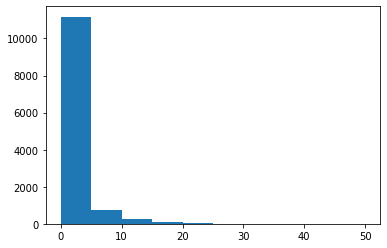

In [44]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.hist(freqs)
plt.show()

### Find collocations for 'self' in this corpus.

In [114]:
import nltk

# statistical measure for bigrams
bigram_measures = nltk.collocations.BigramAssocMeasures()

# Drop ngrams without 'self' as a member
self_filter = lambda *w: 'self' not in w

# Get top 10 collocates for all the docs in the corpus
collocates = []
for vec in tqdm(corpus, total=12302):
    # to lower
    vec = [word.lower() for word in vec]
    # get collocations
    finder = nltk.collocations.BigramCollocationFinder.from_words(vec, window_size=4)
    # filter out bigrams without term 'self'
    finder.apply_ngram_filter(self_filter)
    # get top 10 collocates
    collocates.append(finder.score_ngrams(bigram_measures.likelihood_ratio)[:10])

In [115]:
data = []
for key,rom_freq,doc_collocates in zip(corpus.corpus_meta, freqs, collocates):
    if len(doc_collocates) == 0:
        data.append({'key':key,'rom_freq':rom_freq})
    else:
        doc_data = {}
        for collocate in doc_collocates:
            words,likelihood = collocate
            if words[0] == 'self':
                word = words[1]
            else:
                word = words[0]
            doc_data[word] = likelihood
        data.append({'key':key,'rom_freq':rom_freq, **doc_data})

full_df = pd.DataFrame.from_dict(data)

In [116]:
full_df.fillna(0, inplace=True)

In [118]:
full_df.shape

(12302, 14166)

In [62]:
import pandas as pd
freq_df = pd.DataFrame(zip(corpus.corpus_meta, freqs, collocates))
freq_df.columns = ["doc","freq","collocates"]

### Dictionary

There's a problem with the trained topic model—the Dictionary sucks! Let's try to get to the bottom of it...

In [5]:
from gensim.corpora import Dictionary

# Get corpus used for LDA Model
whole_corpus = JSTORCorpus.load('data/whole-corpus.p')

# Create dictionary
dct = Dictionary(whole_corpus.iter_lower())
# dct.filter_extremes(no_below=5)
# dct.filter_n_most_frequent(remove_n=50)
# dct.save('models/corpus-lower-dct')

Corpus loaded from data/whole-corpus.p


KeyboardInterrupt: 